# 3b. Evaluate group snapshots

In the last notebook, I showed how to prepare group snapshots using `patientflow`. Now, let's think about how to evaluate those models. The goal is to evaluate how well a predicted bed count distribution compares with the observed bed counts at each prediction time over the period of the test set. 

There are various approaches. Here I demonstrate two approaches. 

### Comparing observed values with expected

A common approach is to express the difference between the expectation of a probability distrubion, and the observed value in terms of Mean Absolute Error (MAE), which avoids positive and negative deviations cancelling each other out. The error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE). 

I also plot the difference between expected and observed, which is more revealing than calculating a single number, as it gives a sense of the spread of errors, and whether the model tends to over- or underestimate. 

### Visual approaches that evaluate the whole distribution

Other methods, such as Quantile-Quantile (QQ) Plots appraise the performance of the model across the whole distribution. If a model predicts the tails of a distribution well, the observed number of beds would appear in the lowest tenth of the distribution for 10% of prediction moments, and likewise in the highest tenth for 10% of prediction moments. 

Using such methods with discrete variables (such as bed counts) is nuanced because the Cumulative Distribution Function (CDF) of a discrete distribution is not continuous. A QQ plot can be difficult to interpret if values are often low or zero. Moreover, in our case, we want to evaluate each observed value for a snapshot against the predicted distribution for that snapshot; thus we are using a different predicted distribution each time. 

I show two approaches to evaluating the performance of models that predict discrete distributions when each observations lies on its own CDF: 

* Randomised Probabilility Integral Tansform (PIT) Histogram
* QQ plots adjusted to handle discrete distributions 

More information is given below. 

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) at UCLH to demonstrate the evaluation. The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




## Loading real patient data

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date


Inferred project root: /Users/zellaking/Repos/patientflow


The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [3]:
#  load config file
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

See previous notebooks for more on the code below. 

In [4]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 
)

# set prediction times
prediction_times = ed_visits.prediction_time.unique()

# define variables to exclude 
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

# set ordinal mappings
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-115",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }

Split sizes: [62071, 10415, 29134]


We loop through each prediction time, training a model, using balanced training set and re-calibration on the validation set. Here I'm using a minimal hyperparameter grid for expediency. 

In [5]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

# create a dictionary to store the trained models
trained_models = {}  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Prepare group snapshots

We will now iterate over all group snapshots, to create the following

* a prediction probability distribution for all group snapshots
* the observed number of patients with the outcome for each group snapshot

In [6]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    X_test, y_test = prepare_patient_snapshots(
        df=test_visits, 
        prediction_time=_prediction_time, 
        single_snapshot_per_visit=False,
        exclude_columns=exclude_from_training_data, 
        visit_col='visit_number'
    )

    group_snapshots_dict = prepare_group_snapshot_dict(
        test_visits[test_visits.prediction_time == _prediction_time]
        )
    # get probability distribution for this time of day
    prob_dist_dict_all[model_key] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, trained_models[model_key]
        )


Processing :(22, 0)

Processing :(15, 30)

Processing :(6, 0)

Processing :(12, 0)

Processing :(9, 30)


## Evaluate group snapshots

### Comparing observed with expected values

The mean difference between observed and expected values are reported below. 

In [7]:
from patientflow.evaluate import calc_mae_mpe
results = calc_mae_mpe(prob_dist_dict_all)

print("\nTime    MAE    MPE")
print("----------------------")
for prediction_time, values in results.items():
    # Extract time by finding the underscore and formatting what comes after
    time_str = prediction_time.split('_')[1]
    formatted_time = f"{time_str[:2]}:{time_str[2:]}"
    print(f"{formatted_time}  {values['mae']:<6.2f}  {values['mpe']:.2f}%")



Time    MAE    MPE
----------------------
06:00  1.47    31.01%
09:30  1.51    36.08%
12:00  2.21    32.29%
15:30  2.67    22.75%
22:00  3.21    24.90%


The 06:00 and 09:00 models have the lowest Mean Absolute Error but from a previous notebook we know that they also have the smallest number of patients admitted. Their Mean Percentage Errors were higher than for the later prediction times. While the later times have larger absolute errors, they are proportionally nearer to the actual values. 

We can plot the observed values against the expected, as shown below.

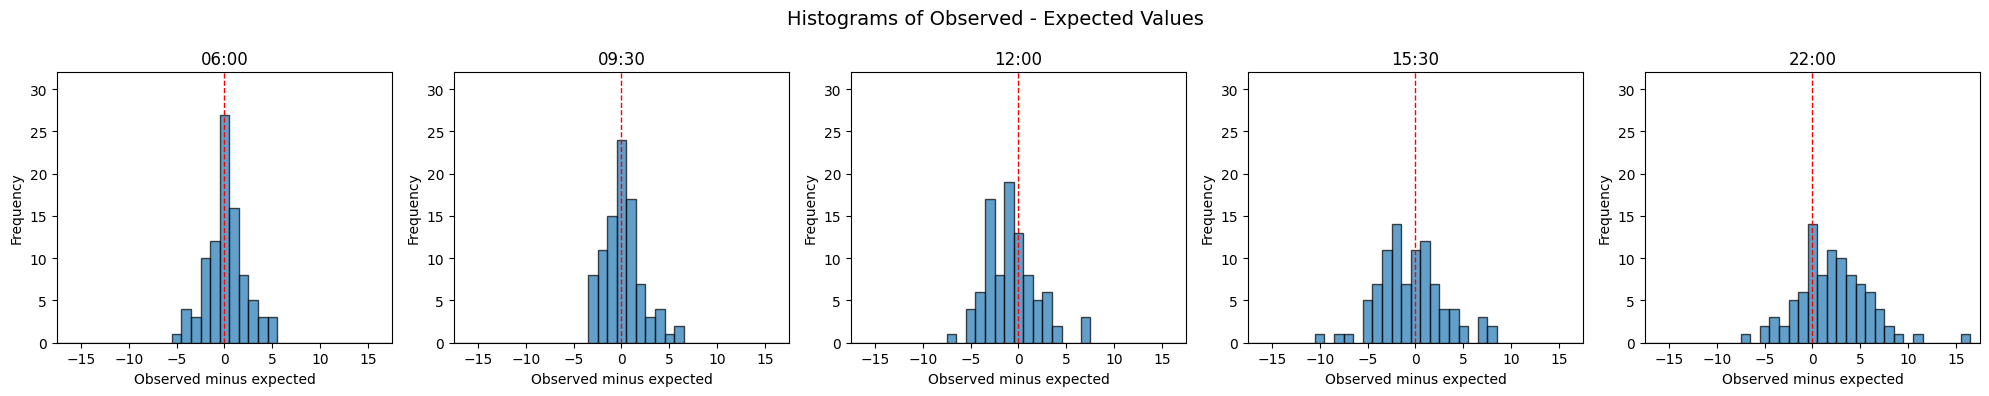

In [8]:
from patientflow.viz.evaluation_plots import plot_observed_against_expected
plot_observed_against_expected(results)

From the plots above: 
* The 06:00 and 09:30 models data shows a slight positive bias, with more values above zero than below, suggesting under-prediction (observed values higher than expected)
* The 12:00 model appears more spread out with a wider range of error
* The 15:30 model has a slight negative bias
* The 22:00 time slot displays a distinct positive skew, with most values above zero, suggesting consistent under-prediction

## Visual approaches that evaluate the whole distribution

### Randomised Probabilility Integral Tansform (PIT) Histogram

As noted in the introduction, we want to evaluate  each observed value against the predicted distribution for that snapshot; thus we are using a different predicted distribution each time. We have a model that determines a Cumulative Distribution Function (CDF) Fi(x) specific to the discrete random variable associated with the ith observation in a series of counts and we want to assess the accuracy of the underlying model.

For continuous variables, there's an elegant solution called the Probability Integral Transform (PIT) developed by [Czado et al, 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1541-0420.2009.01191.x). Each observation can be mapped to the corresponding value of its CDF; this is referred to as a a probability integral transform (PIT). If the underlying model is well calibrated, a histogram of these PIT values would be uniform, and a cumulative plot of PIT values would have a slope of 1.

For a discrete random variable, instead of a single point, each observation corresponds to a range on the CDF. We identify the range of the cdf Fi(x) associated with the observation oi. For discrete integer variables, this has a lower limit, upper limit and mid-points given by
li = Fi(oi-1), ui = Fi(oi) and mi = 𝑙𝑖+𝑢𝑖2.

The randomized PIT histogram is obtained by allotting to each observation oi a PIT value sampled at random from the range [li,ui] and then forming a histogram of these (with one convention being to have 10 bins of width 0.1). A well performing model will give a uniform histogram (subject to randomisation and binning).


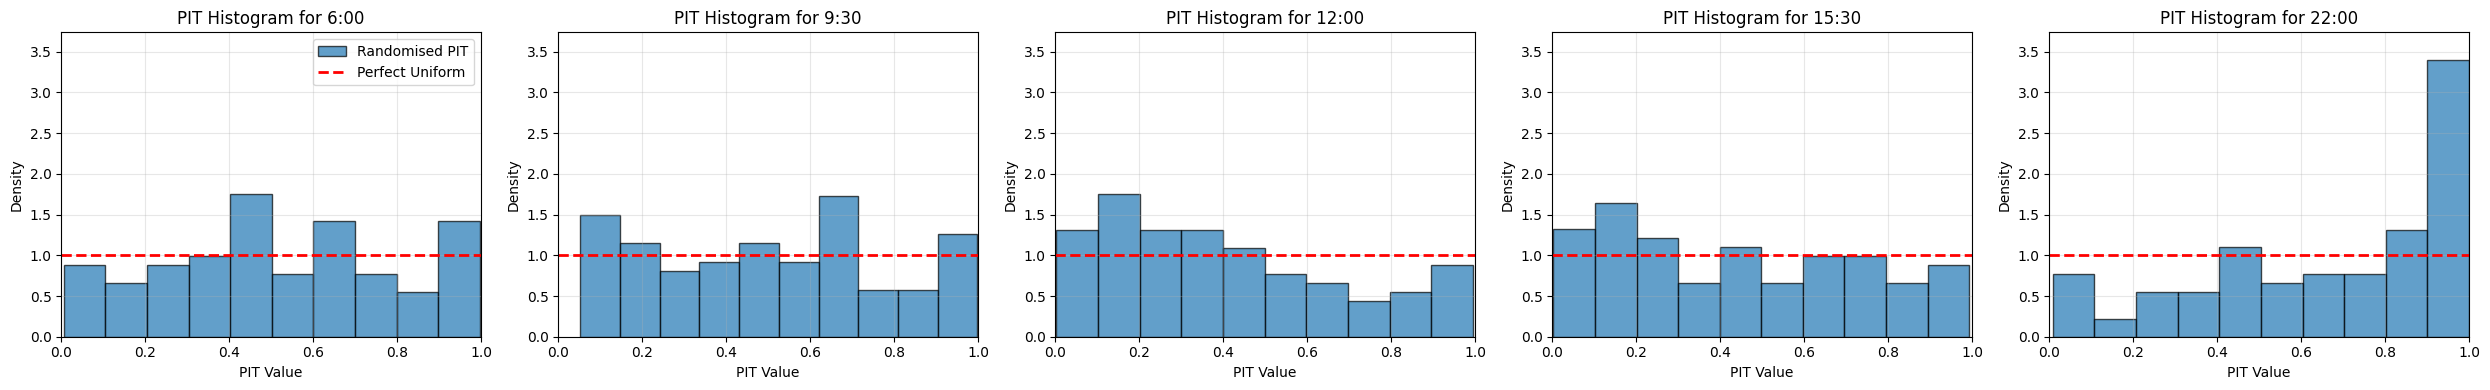

In [31]:
from patientflow.viz.randomised_pit_plot import randomised_pit_plot

randomised_pit_plot(prediction_times, prob_dist_dict_all)

### Adjusted QQ plot

 In prior work, we developed an alternative to the QQ plot suited to discrete random variables. See Figure 9 in [Pagel et al (2017)](https://www.sciencedirect.com/science/article/pii/S2211692316300418).

In the Adjusted QQ Plot the x axis represents the CDF from the model's predictions (in grey) and the y axis represents the proportion of cumulative probability mass that fall at or below each CDF threshold. 

Both sets of points are plotted with the predicted CDF values on the x axis. The difference is:

* Grey points: Show the full predicted CDF curve
* Colored points: Show only where the actual observations fall along that their predicted CDF

If the observed cdf points track the model cdfs, the model is well calibrated. 

Note that the model points (grey) represent discrete probability mass, averaged over all prediction times in the test set. Because discrete probability mass may be stepped, the model points may not follow the y=x line.

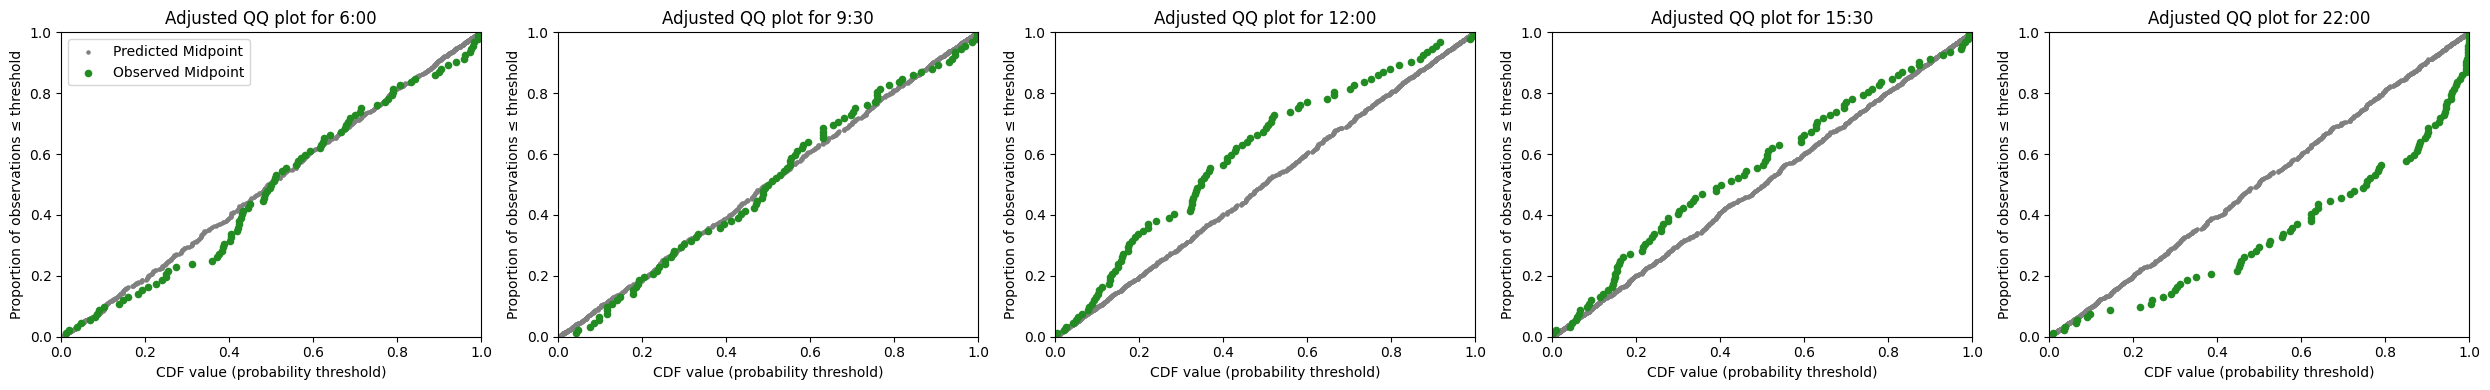

In [ ]:
from patientflow.viz.adjusted_qq_plot import adjusted_qq_plot

adjusted_qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions")

In the two sets of plot above, the 06:00 and 09:30 perform. At 12:00 and 15:30 the predicted probabilities are lower than the observed frequencies, and at 22:00 they are higher. At 22:00, more patients are being admitted than the model expects. 

From these plots, there appears to be some bias introduded at the aggregation to group snapshots, that has not been propogated through from the patient-level predictions. 

Further work is needed to isolate the reason for this bias. 

## Conclusions

Here I have demonstrated some methods for evaluating predicted distributions, including summary statistics, Randomised PIT Histograms and Adjusted QQ Plots.  

We prefer plots over summary statistics like MAE or MPE. Plots allow us to compare the predicted and observed distributions across the full probability range. This can be helpful for detecting issues in the tails of distributions. For instance, in the 22:00 time, the plot reveals deviations in the upper quantiles that summary statistics would obscure. This helps to identify where in the modelling pipeline model bias is being introduced, and identify aspects that need to be investigated further. 

I demonstrated two approaches to such plots. We prefer the Adjusted QQ to the Randomised PIT approach because is not subject to randomisation and binning, and can reveal sparse areas of the cdf (eg around 0.3 CDF value on the 12:00 plot). I will make use of this plot in later notebooks evaluating our emergency demand predictions by specialty. 
